In [2]:
# Acronym Matching Analysis Notebook

# Cell 1: Import Required Libraries
import pandas as pd
import numpy as np
import re
from Levenshtein import jaro_winkler, distance as levenshtein_distance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import jellyfish
from fuzzywuzzy import fuzz
import string
import warnings
warnings.filterwarnings('ignore')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Cell 2: Text Preprocessing Functions
def preprocess_text(text):
    """Basic text preprocessing: lowercase and remove special characters"""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

def get_bigrams(text):
    """Generate character bigrams from text"""
    text = preprocess_text(text)
    return [text[i:i+2] for i in range(len(text)-1)]

# Text Preprocessing Functions Explanation

```python
def preprocess_text(text):
    """Basic text preprocessing: lowercase and remove special characters"""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

def get_bigrams(text):
    """Generate character bigrams from text"""
    text = preprocess_text(text)
    return [text[i:i+2] for i in range(len(text)-1)]
```

## Function 1: `preprocess_text(text)`

This function performs essential text normalization before similarity calculations:

1. **Type Conversion**: Converts the input to a string with `str(text)` to ensure the function works even if non-string values are passed
2. **Lowercase Conversion**: Transforms all text to lowercase with `.lower()` to make comparisons case-insensitive
3. **Special Character Removal**: Uses regular expression `re.sub(r'[^\w\s]', '', text)` to:
   - Keep only word characters (`\w` = letters, digits, underscores)
   - Keep whitespace (`\s`)
   - Remove all punctuation and special characters

**Example:**
```
Input:  "Bank of America (BoA)!"
Output: "bank of america boa"
```

## Function 2: `get_bigrams(text)`

This function creates character-level bigrams (pairs of adjacent characters):

1. **Preprocessing**: First calls `preprocess_text()` to clean and normalize the input text
2. **Bigram Generation**: Uses list comprehension to create all consecutive character pairs:
   - `[text[i:i+2] for i in range(len(text)-1)]` iterates through the text
   - For each position `i`, it extracts the substring from position `i` to `i+2` (two characters)
   - Stops at `len(text)-1` to avoid going beyond the string's end

**Example:**
```
Input:  "McDonald's"
After preprocessing: "mcdonalds"
Output bigrams: ["mc", "cd", "do", "on", "na", "al", "ld", "ds"]
```

### Why These Functions Matter for Acronym Matching

- **Consistent Comparison**: Preprocessing ensures fair comparison regardless of capitalization or punctuation
- **Character-Level Analysis**: Bigrams capture character-level patterns that help identify similarity even with spelling variations
- **Fuzzy Matching Support**: Enables the Jaccard Bigram similarity metric that measures overlap between character pairs, making it useful for detecting partial acronym matches

These functions form the foundation for more sophisticated string similarity algorithms used in the acronym matching process.ithms used in the acronym matching process.

In [10]:
# 1. Jaro-Winkler similarity
def calc_jaro_winkler(str1, str2):
    """Calculate Jaro-Winkler similarity"""
    return jaro_winkler(str1, str2)

In [12]:
# 2. Damerau-Levenshtein similarity (normalized)
def calc_damerau_levenshtein(str1, str2):
    """Calculate normalized Damerau-Levenshtein similarity"""
    max_len = max(len(str1), len(str2))
    if max_len == 0:
        return 1.0
    return 1 - levenshtein_distance(str1, str2) / max_len

In [14]:

# 3. TF-IDF Cosine similarity
def calc_tfidf_cosine(str1, str2):
    """Calculate TF-IDF cosine similarity"""
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform([str1, str2])
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]


In [16]:

# 4. Jaccard Bigram similarity
def calc_jaccard_bigram(str1, str2):
    """Calculate Jaccard similarity on character bigrams"""
    set1 = set(get_bigrams(str1))
    set2 = set(get_bigrams(str2))
    
    if not set1 and not set2:
        return 1.0
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    return intersection / union


In [18]:

# 5. Soundex Match (binary score)
def calc_soundex_match(str1, str2):
    """Calculate binary Soundex match (1 if match, 0 if not)"""
    soundex1 = jellyfish.soundex(str1)
    soundex2 = jellyfish.soundex(str2)
    return 1 if soundex1 == soundex2 else 0


In [20]:

# 6. Token Sort Ratio
def calc_token_sort_ratio(str1, str2):
    """Calculate token sort ratio using fuzzywuzzy"""
    return fuzz.token_sort_ratio(str1, str2) / 100.0


In [22]:

# 7. Contains Ratio
def calc_contains_ratio(str1, str2):
    """Calculate contains ratio - how much of the shorter string is in the longer one"""
    str1 = str1.lower()
    str2 = str2.lower()
    
    if len(str1) <= len(str2):
        shorter, longer = str1, str2
    else:
        shorter, longer = str2, str1
    
    matches = sum(1 for char in shorter if char in longer)
    return matches / len(shorter) if shorter else 1.0


In [24]:

# 8. Fuzzy Matching with Levenshtein Distance
def calc_fuzzy_levenshtein(str1, str2, threshold=0.7):
    """Fuzzy matching using Levenshtein distance with a threshold"""
    max_len = max(len(str1), len(str2))
    if max_len == 0:
        return 1.0
    
    distance = levenshtein_distance(str1, str2)
    similarity = 1 - (distance / max_len)
    
    # Apply threshold - return similarity if above threshold, else 0
    return similarity if similarity >= threshold else similarity


In [26]:

# 9. Trie with Approximate Matching
class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_end_of_word = False
        self.word = None

class Trie:
    def __init__(self):
        self.root = TrieNode()
    
    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
        node.is_end_of_word = True
        node.word = word
    
    def search_approximate(self, word, max_distance=2):
        """Search for words in trie with max_distance edits"""
        results = []
        
        # Helper function using recursion
        def _search_recursive(node, prefix, remaining_distance, best_matches):
            if node.is_end_of_word:
                distance = levenshtein_distance(word, node.word)
                if distance <= max_distance:
                    similarity = 1 - (distance / max(len(word), len(node.word)))
                    best_matches.append((node.word, similarity))
            
            if remaining_distance > 0:
                # Try inserting a character
                for char in node.children:
                    _search_recursive(node.children[char], prefix + char, remaining_distance - 1, best_matches)
            
            # Continue normal search
            for char in node.children:
                if char in word:
                    _search_recursive(node.children[char], prefix + char, remaining_distance, best_matches)
                elif remaining_distance > 0:
                    _search_recursive(node.children[char], prefix + char, remaining_distance - 1, best_matches)
        
        _search_recursive(self.root, "", max_distance, results)
        
        # Return best match similarity or 0 if none found
        return max([sim for _, sim in results]) if results else 0

def calc_trie_approximate(str1, str2):
    """Calculate similarity using Trie with approximate matching"""
    trie = Trie()
    trie.insert(str2)
    return trie.search_approximate(str1)


In [28]:

# 10. Word2Vec/Embedding Models Similarity (simplified character-level embedding)
def calc_embedding_similarity(str1, str2):
    """Calculate similarity using a simple character embedding approach"""
    # Create a simple character embedding space
    chars = string.ascii_lowercase + string.digits + ' '
    char_vectors = {c: np.random.rand(5) for c in chars}  # 5-dimensional embedding
    
    # Get embeddings for each string
    def get_embedding(s):
        s = s.lower()
        vec = np.zeros(5)
        for char in s:
            if char in char_vectors:
                vec += char_vectors[char]
        return vec / (len(s) + 1e-10)  # Avoid division by zero
    
    # Calculate cosine similarity between embeddings
    vec1 = get_embedding(str1)
    vec2 = get_embedding(str2)
    
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    return dot_product / (norm1 * norm2) if norm1 * norm2 > 0 else 0


In [30]:

# 11. Aho-Corasick Algorithm (adapted for similarity)
class AhoCorasick:
    def __init__(self):
        self.trie = {}
        self.outputs = {}
        self.fail = {}
        self.built = False
    
    def add_word(self, word):
        node = self.trie
        for char in word:
            if char not in node:
                node[char] = {}
            node = node[char]
        self.outputs[id(node)] = [word]
    
    def build_automaton(self):
        queue = []
        self.fail = {}
        
        # Initialize fail transitions for depth 1 nodes
        for char, node in self.trie.items():
            self.fail[id(node)] = self.trie
            queue.append(node)
        
        # BFS to build fail transitions
        while queue:
            curr = queue.pop(0)
            
            for char, next_node in curr.items():
                fail_state = self.fail[id(curr)]
                
                while fail_state != self.trie and char not in fail_state:
                    fail_state = self.fail[id(fail_state)]
                
                if char in fail_state:
                    self.fail[id(next_node)] = fail_state[char]
                else:
                    self.fail[id(next_node)] = self.trie
                
                if id(self.fail[id(next_node)]) in self.outputs:
                    if id(next_node) not in self.outputs:
                        self.outputs[id(next_node)] = []
                    self.outputs[id(next_node)].extend(self.outputs[id(self.fail[id(next_node)])])
                
                queue.append(next_node)
        
        self.built = True
    
    def search(self, text):
        if not self.built:
            self.build_automaton()
        
        matches = []
        node = self.trie
        
        for i, char in enumerate(text):
            while node != self.trie and char not in node:
                node = self.fail[id(node)]
            
            if char in node:
                node = node[char]
            
            if id(node) in self.outputs:
                for word in self.outputs[id(node)]:
                    matches.append((i - len(word) + 1, word))
        
        return matches

def calc_aho_corasick(str1, str2):
    """Calculate similarity using Aho-Corasick algorithm"""
    # For single pair comparison, we're adapting Aho-Corasick to check substrings
    ac = AhoCorasick()
    
    # Add all substrings of str2 of length > 2
    for i in range(len(str2)):
        for j in range(i + 2, len(str2) + 1):
            ac.add_word(str2[i:j])
    
    matches = ac.search(str1)
    
    if not matches:
        return 0
    
    # Calculate coverage (how much of str1 is matched by substrings of str2)
    matched_positions = set()
    for pos, match in matches:
        for i in range(pos, pos + len(match)):
            if i < len(str1):
                matched_positions.add(i)
    
    return len(matched_positions) / len(str1) if str1 else 0


In [32]:
# Main function to calculate all similarity scores
def calculate_all_similarities(df):
    """Calculate all similarity scores for each acronym-full name pair"""
    
    # Initialize lists for scores
    scores = {
        'Jaro-Winkler': [],
        'Damerau-Levenshtein': [],
        'TF-IDF Cosine': [],
        'Jaccard Bigram': [],
        'Soundex Match': [],
        'Token Sort Ratio': [],
        'Contains Ratio': [],
        'Fuzzy Levenshtein': [],
        'Trie Approximate': [],
        'Embedding Similarity': [],
        'Aho-Corasick': []
    }
    
    # Calculate scores for each pair
    for _, row in df.iterrows():
        acronym = row['Acronym']
        full_name = row['Full Name']
        
        scores['Jaro-Winkler'].append(calc_jaro_winkler(acronym, full_name))
        scores['Damerau-Levenshtein'].append(calc_damerau_levenshtein(acronym, full_name))
        scores['TF-IDF Cosine'].append(calc_tfidf_cosine(acronym, full_name))
        scores['Jaccard Bigram'].append(calc_jaccard_bigram(acronym, full_name))
        scores['Soundex Match'].append(calc_soundex_match(acronym, full_name))
        scores['Token Sort Ratio'].append(calc_token_sort_ratio(acronym, full_name))
        scores['Contains Ratio'].append(calc_contains_ratio(acronym, full_name))
        scores['Fuzzy Levenshtein'].append(calc_fuzzy_levenshtein(acronym, full_name))
        scores['Trie Approximate'].append(calc_trie_approximate(acronym, full_name))
        scores['Embedding Similarity'].append(calc_embedding_similarity(acronym, full_name))
        scores['Aho-Corasick'].append(calc_aho_corasick(acronym, full_name))
    
    # Add scores to dataframe
    for algo, score_list in scores.items():
        df[algo] = score_list
    
    return df

In [34]:
# Cell 4: Specialized Acronym Identification Function
def acronym_match_score(acronym, full_name):
    """Score specifically for identifying correct acronyms based on formation patterns"""
    score = 0
    max_score = 5
    
    # Convert to lowercase for comparison
    acronym = str(acronym).lower()
    full_name = str(full_name).lower()
    
    # Remove punctuation and split words
    full_name = re.sub(r'[^\w\s]', ' ', full_name)
    words = full_name.split()
    
    # Rule 1: First letter of each word
    first_letters = ''.join([word[0] for word in words if word])
    if acronym.lower() == first_letters.lower():
        score += 2
    
    # Rule 2: First letters of major words (skipping minor words)
    skip_words = {'and', 'of', 'the', 'a', 'an', 'in', 'for', 'to', 'with'}
    major_words = [word for word in words if word.lower() not in skip_words]
    major_first_letters = ''.join([word[0] for word in major_words if word])
    if acronym.lower() == major_first_letters.lower():
        score += 1.5
        
    # Rule 3: Special handling for prefixes like "Mc" or compound words
    compound_first_letters = []
    for word in words:
        if word.lower().startswith('mc'):
            compound_first_letters.append(word[0:1] + word[2:3])
        else:
            compound_first_letters.append(word[0:1] if word else '')
    
    compound_acronym = ''.join(compound_first_letters).lower()
    if acronym.lower() == compound_acronym:
        score += 1.5
        
    # Rule 4: Check for character presence and position
    char_positions = {}
    for i, char in enumerate(full_name.replace(' ', '')):
        if char not in char_positions:
            char_positions[char] = i
    
    acronym_chars_in_order = True
    prev_pos = -1
    for char in acronym:
        if char in char_positions and char_positions[char] > prev_pos:
            prev_pos = char_positions[char]
        else:
            acronym_chars_in_order = False
            break
    
    if acronym_chars_in_order:
        score += 1
    
    return min(score / max_score, 1.0)  # Normalize to [0,1]

In [36]:
# Cell 5: Main Similarity Calculation Function
def calculate_all_similarities(df):
    """Calculate all similarity scores for each acronym-full name pair"""
    
    # Initialize lists for scores
    score_algorithms = [
        ('Jaro-Winkler', calc_jaro_winkler),
        ('Damerau-Levenshtein', calc_damerau_levenshtein),
        ('TF-IDF Cosine', calc_tfidf_cosine),
        ('Jaccard Bigram', calc_jaccard_bigram),
        ('Soundex Match', calc_soundex_match),
        ('Token Sort Ratio', calc_token_sort_ratio),
        ('Contains Ratio', calc_contains_ratio),
        ('Fuzzy Levenshtein', calc_fuzzy_levenshtein),
        ('Trie Approximate', calc_trie_approximate),
        ('Embedding Similarity', calc_embedding_similarity),
        ('Aho-Corasick', calc_aho_corasick)
    ]
    
    # Calculate scores for each pair
    for algo_name, algo_func in score_algorithms:
        df[algo_name] = df.apply(lambda row: algo_func(row['Acronym'], row['Full Name']), axis=1)
    
    # Add specialized acronym match score
    df['Acronym Formation Score'] = df.apply(lambda row: acronym_match_score(row['Acronym'], row['Full Name']), axis=1)
    
    return df

In [38]:
# Cell 6: Data Preparation Function
def prepare_data():
    """Prepare and load data for analysis"""
    try:
        # Load data
        df = pd.read_excel("Acronym.xlsx")
        print(f"Successfully loaded data with {len(df)} rows")
        
        # Calculate similarity scores
        result_df = calculate_all_similarities(df)
        
        # Round scores for readability
        for col in result_df.columns:
            if col not in ['Acronym', 'Full Name']:
                result_df[col] = result_df[col].round(3)
        
        # Display results
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        print("\nSample of results (first 5 rows):")
        print(result_df.head())
        
        # Save results to CSV
        result_df.to_csv("acronym_similarity_results.csv", index=False)
        print("\nFull results saved to 'acronym_similarity_results.csv'")
        
        return result_df
    
    except Exception as e:
        print(f"Error: {e}")
        return None

In [40]:
# Cell 7: Main Execution Function
def main():
    # Prepare and analyze data
    result_df = prepare_data()
    return result_df

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_boxplot(result_df, score_columns):
    """Create boxplot comparing all similarity algorithms"""
    plt.figure(figsize=(14, 8))
    
    # Sort columns by their mean score values for better visualization
    sorted_columns = result_df[score_columns].mean().sort_values(ascending=False).index.tolist()
    
    # Create the boxplot with sorted columns
    ax = sns.boxplot(data=result_df[sorted_columns], palette='viridis')
    
    # Add mean markers
    means = result_df[sorted_columns].mean()
    for i, col in enumerate(sorted_columns):
        plt.plot(i, means[col], marker='o', color='red', markersize=8)
    
    plt.title('Distribution of Similarity Scores Across Algorithms', fontsize=16)
    plt.ylabel('Similarity Score', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add a legend for the mean marker
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='r', 
                             markersize=8, label='Mean Score')]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(result_df, score_columns):
    """Create correlation heatmap between algorithms"""
    plt.figure(figsize=(12, 10))
    correlation_matrix = result_df[score_columns].corr()
    
    # Sort algorithms by their mean performance
    sorted_cols = result_df[score_columns].mean().sort_values(ascending=False).index
    sorted_corr = correlation_matrix.loc[sorted_cols, sorted_cols]
    
    sns.heatmap(sorted_corr, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', square=True, linewidths=0.5, cbar_kws={'shrink': .8})
    plt.title('Correlation Between Similarity Algorithms', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()

def plot_acronym_formation_score_histogram(result_df):
    """Create detailed histogram for Acronym Formation Score"""
    plt.figure(figsize=(12, 8))
    
    # Create histogram with KDE
    ax = sns.histplot(result_df['Acronym Formation Score'], bins=20, 
                     kde=True, color='skyblue', edgecolor='black', alpha=0.7)
    
    # Add vertical lines for key statistics
    mean_score = result_df['Acronym Formation Score'].mean()
    median_score = result_df['Acronym Formation Score'].median()
    
    plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, alpha=0.7)
    plt.axvline(median_score, color='green', linestyle='--', linewidth=2, alpha=0.7)
    
    # Add text annotations
    plt.text(mean_score+0.02, plt.ylim()[1]*0.95, f'Mean: {mean_score:.3f}', 
             color='red', fontsize=12, va='top')
    plt.text(median_score-0.02, plt.ylim()[1]*0.85, f'Median: {median_score:.3f}', 
             color='green', fontsize=12, va='top', ha='right')
    
    # Highlight score distribution
    plt.text(0.05, plt.ylim()[1]*0.7, 
             f"Score Distribution:\n"
             f"- Perfect Matches (1.0): {(result_df['Acronym Formation Score'] == 1.0).sum()}\n"
             f"- Strong Matches (≥0.8): {(result_df['Acronym Formation Score'] >= 0.8).sum()}\n"
             f"- Moderate Matches (0.4-0.8): {((result_df['Acronym Formation Score'] >= 0.4) & (result_df['Acronym Formation Score'] < 0.8)).sum()}\n"
             f"- Weak Matches (<0.4): {(result_df['Acronym Formation Score'] < 0.4).sum()}",
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
             fontsize=12)
    
    plt.title('Distribution of Acronym Formation Scores', fontsize=18)
    plt.xlabel('Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_algorithm_comparison_barchart(result_df):
    """Create bar chart comparing mean performance of all algorithms"""
    plt.figure(figsize=(14, 8))
    
    # Calculate mean scores for each algorithm (exclude non-numeric columns)
    numeric_cols = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    mean_scores = result_df[numeric_cols].mean().sort_values(ascending=False)
    
    # Create bar chart with gradient colors
    bars = plt.bar(mean_scores.index, mean_scores.values, 
                  color=plt.cm.viridis(np.linspace(0, 1, len(mean_scores))))
    
    # Add value labels on top of bars
    for i, (algo, score) in enumerate(mean_scores.items()):
        plt.text(i, score + 0.01, f'{score:.3f}', ha='center', fontsize=11)
    
    # Highlight best algorithm
    best_algo = mean_scores.index[0]
    best_score = mean_scores.iloc[0]
    plt.text(len(mean_scores)/2, 0.85, 
             f'Best Overall Algorithm: {best_algo}\nAverage Score: {best_score:.3f}',
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
             fontsize=14, ha='center')
    
    plt.title('Average Performance of Similarity Algorithms', fontsize=18)
    plt.ylabel('Mean Similarity Score', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

def plot_mcdonalds_case_study(result_df):
    """Create specialized visualization for McDonald's example"""
    # Extract McDonald's examples
    mcd_df = result_df[result_df['Full Name'] == 'McDonalds'].copy()
    
    if len(mcd_df) == 0:
        print("No McDonald's examples found in the dataset.")
        return
    
    # Sort by Acronym Formation Score
    mcd_df = mcd_df.sort_values('Acronym Formation Score', ascending=False)
    
    # Select algorithms to compare (exclude non-numeric columns)
    numeric_cols = mcd_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    # Select a subset of meaningful algorithms
    algos_to_compare = ['Acronym Formation Score', 'Jaro-Winkler', 
                       'Damerau-Levenshtein', 'Token Sort Ratio', 
                       'Contains Ratio', 'Fuzzy Levenshtein']
    # Make sure all selected algorithms exist in the dataframe
    algos_to_compare = [algo for algo in algos_to_compare if algo in numeric_cols]
    
    plt.figure(figsize=(14, 8))
    
    # Create heatmap for all algorithms across McDonald's acronyms
    data = mcd_df[algos_to_compare].T
    data.columns = mcd_df['Acronym']
    
    # Create heatmap with annotations
    ax = sns.heatmap(data, annot=True, fmt='.3f', cmap='YlGnBu', 
                    linewidths=0.5, cbar_kws={'label': 'Similarity Score'})
    
    plt.title("Algorithm Performance on McDonald's Acronym Variants", fontsize=18)
    plt.ylabel('Algorithm', fontsize=14)
    plt.xlabel('Acronym Variant', fontsize=14)
    
    # Add text explanation
    plt.figtext(0.5, 0.01, 
                "This heatmap shows how different algorithms score the various McDonald's acronym variants.\n"
                "The Acronym Formation Score correctly identifies 'MCD' as the conventional acronym.",
                ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

def plot_algorithm_performance_by_group(result_df):
    """Compare algorithm performance on different groups of acronyms"""
    # Ensure Acronym Type column exists
    if 'Acronym Type' not in result_df.columns:
        # Create a new column for grouping acronyms if it doesn't exist
        def categorize_acronym(row):
            acronym = row['Acronym']
            full_name = row['Full Name']
            
            # Check if acronym is exact first letters of words
            words = full_name.split()
            first_letters = ''.join([w[0].upper() for w in words if w])
            
            if acronym.upper() == first_letters:
                return 'Exact First Letters'
            
            # Check if it's a shortened form (like Woolies -> Woolworths)
            if acronym.lower() in full_name.lower() or full_name.lower() in acronym.lower():
                return 'Shortened Form'
                
            # Check for special cases like MCD -> McDonalds
            if 'McDonald' in full_name and acronym in ['MCD', 'MD', 'MLD']:
                if acronym == 'MCD':
                    return 'Special Pattern (Correct)'
                else:
                    return 'Special Pattern (Incorrect)'
            
            return 'Other'
        
        result_df['Acronym Type'] = result_df.apply(categorize_acronym, axis=1)
    
    # Select key algorithms to compare (must be numeric)
    numeric_cols = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    key_algos = [col for col in ['Acronym Formation Score', 'Jaro-Winkler', 'Token Sort Ratio', 
                                'Fuzzy Levenshtein', 'Embedding Similarity'] 
                if col in numeric_cols]
    
    # Calculate mean scores by group
    group_scores = result_df.groupby('Acronym Type')[key_algos].mean()
    
    # Create grouped bar chart
    plt.figure(figsize=(14, 8))
    ax = group_scores.plot(kind='bar', width=0.8, figsize=(14, 8))
    
    plt.title('Algorithm Performance by Acronym Type', fontsize=18)
    plt.ylabel('Mean Similarity Score', fontsize=14)
    plt.xlabel('Acronym Type', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.legend(fontsize=12, title='Algorithm')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=9)
    
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

def create_visualizations(result_df):
    """Generate comprehensive visualizations for similarity scores"""
    # Define score columns (excluding non-numeric and non-score columns)
    # This is the key fix - make sure we only include numeric columns
    score_columns = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Create visualizations
    print("\n1. Comparing Overall Algorithm Performance:")
    plot_algorithm_comparison_barchart(result_df)
    
    print("\n2. Detailed Analysis of Acronym Formation Score:")
    plot_acronym_formation_score_histogram(result_df)
    
    print("\n3. Case Study: McDonald's Acronym Variants:")
    plot_mcdonalds_case_study(result_df)
    
    print("\n4. Algorithm Performance by Acronym Type:")
    plot_algorithm_performance_by_group(result_df)
    
    print("\n5. Distribution of Scores Across Algorithms:")
    plot_boxplot(result_df, score_columns)
    
    print("\n6. Correlation Between Different Algorithms:")
    plot_correlation_heatmap(result_df, score_columns)
    
    print("\nAll visualizations displayed successfully.")

# The following functions are for detailed analysis (for personal use)
def analyze_top_bottom_pairs(result_df):
    """Analyze the top and bottom 5 pairs for each algorithm"""
    # Get only numeric columns for analysis
    score_columns = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    results = {}
    
    print("\n=== TOP AND BOTTOM PAIRS ANALYSIS ===\n")
    
    for algo in score_columns:
        # Get top 5 pairs
        top5 = result_df.nlargest(5, algo)[['Acronym', 'Full Name', algo]]
        
        # Get bottom 5 pairs
        bottom5 = result_df.nsmallest(5, algo)[['Acronym', 'Full Name', algo]]
        
        print(f"\n=== {algo} ===")
        
        print("\nTop 5 Matching Pairs:")
        print(top5.to_string(index=False))
        
        print("\nBottom 5 Matching Pairs:")
        print(bottom5.to_string(index=False))
        
        print("\n" + "="*50)
        
        results[algo] = {
            'top5': top5,
            'bottom5': bottom5
        }
    
    return results

def evaluate_performance(result_df):
    """Evaluate and compare the performance of different algorithms"""
    # Get only numeric columns for analysis - this fixes the error
    score_columns = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    performance_analysis = {}
    
    for algo in score_columns:
        # Calculate key performance indicators
        performance_analysis[algo] = {
            'mean_score': result_df[algo].mean(),
            'median_score': result_df[algo].median(),
            'std_dev': result_df[algo].std(),
            'max_score': result_df[algo].max(),
            'min_score': result_df[algo].min()
        }
    
    # Sort algorithms by mean score
    sorted_algorithms = sorted(performance_analysis.items(), 
                              key=lambda x: x[1]['mean_score'], 
                              reverse=True)
    
    # Print performance summary
    print("\n=== ALGORITHM PERFORMANCE SUMMARY ===\n")
    print("Algorithms ranked by mean score:\n")
    
    for i, (algo, stats) in enumerate(sorted_algorithms):
        print(f"{i+1}. {algo}: {stats['mean_score']:.3f} (±{stats['std_dev']:.3f})")
    
    # Identify best algorithm
    best_algo = sorted_algorithms[0][0]
    print(f"\nBest performing algorithm: {best_algo} with mean score {sorted_algorithms[0][1]['mean_score']:.3f}")
    
    return performance_analysis

def generate_detailed_report(result_df):
    """Generate a detailed performance report for each algorithm"""
    # Get only numeric columns for analysis
    score_columns = result_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    print("\n=== COMPREHENSIVE ALGORITHM PERFORMANCE REPORT ===\n")
    
    # Summary statistics
    print("SUMMARY STATISTICS:")
    summary_stats = result_df[score_columns].describe().round(3)
    print(summary_stats)
    print("\n" + "="*70 + "\n")
    
    # Algorithm strengths and weaknesses
    print("ALGORITHM CHARACTERISTICS:\n")
    
    algorithms = {
        'Jaro-Winkler': {
            'strengths': 'Performs well on short strings and gives weight to matching prefixes',
            'weaknesses': 'Less effective when word order differs significantly',
            'best_for': 'Similar length strings with minor variations'
        },
        'Damerau-Levenshtein': {
            'strengths': 'Handles character transpositions, insertions, deletions, and substitutions',
            'weaknesses': 'Poor performance with length differences',
            'best_for': 'Minor spelling errors and character swaps'
        },
        'TF-IDF Cosine': {
            'strengths': 'Considers character frequency patterns',
            'weaknesses': 'May miss structural similarities',
            'best_for': 'Comparing texts with similar vocabulary'
        },
        'Jaccard Bigram': {
            'strengths': 'Handles character order variations within words',
            'weaknesses': 'Sensitive to non-matching character pairs',
            'best_for': 'Texts with similar character patterns'
        },
        'Soundex Match': {
            'strengths': 'Captures phonetic similarity',
            'weaknesses': 'Binary result (match/no match)',
            'best_for': 'Names that sound alike but are spelled differently'
        },
        'Token Sort Ratio': {
            'strengths': 'Handles word order differences',
            'weaknesses': 'Less effective with single-word comparisons',
            'best_for': 'Multi-word strings with rearranged words'
        },
        'Contains Ratio': {
            'strengths': 'Captures substring relationships',
            'weaknesses': 'Doesn\'t consider character position',
            'best_for': 'When one string is a subset of another'
        },
        'Fuzzy Levenshtein': {
            'strengths': 'More flexible version of Levenshtein with threshold control',
            'weaknesses': 'Still struggles with length differences',
            'best_for': 'Fuzzy matching with tolerance for errors'
        },
        'Trie Approximate': {
            'strengths': 'Efficient for large datasets; finds close matches within edit distance',
            'weaknesses': 'Complex implementation; requires parameter tuning',
            'best_for': 'High-performance approximate string matching'
        },
        'Embedding Similarity': {
            'strengths': 'Can capture semantic relationships between words',
            'weaknesses': 'Simple implementation lacks true semantic understanding',
            'best_for': 'Words with similar meanings but different spellings'
        },
        'Aho-Corasick': {
            'strengths': 'Efficient for multiple pattern matching',
            'weaknesses': 'Not designed for similarity measurement',
            'best_for': 'Finding exact substrings efficiently'
        },
        'Acronym Formation Score': {
            'strengths': 'Specifically designed for acronym matching; understands formation patterns',
            'weaknesses': 'Only works for acronyms, not general string similarity',
            'best_for': 'True acronyms derived from initial letters of words'
        }
    }
    
    # Get average scores
    avg_scores = result_df[score_columns].mean()
    
    for algo, info in algorithms.items():
        if algo in avg_scores.index:
            avg_score = avg_scores[algo]
            print(f"{algo} (Avg Score: {avg_score:.3f}):")
            print(f"  - Strengths: {info['strengths']}")
            print(f"  - Weaknesses: {info['weaknesses']}")
            print(f"  - Best for: {info['best_for']}")
            
            # Best and worst matches
            if algo in result_df.columns:
                best_match = result_df.loc[result_df[algo].idxmax()]
                worst_match = result_df.loc[result_df[algo].idxmin()]
                
                print(f"  - Best match: '{best_match['Acronym']}' - '{best_match['Full Name']}' (Score: {best_match[algo]:.3f})")
                print(f"  - Worst match: '{worst_match['Acronym']}' - '{worst_match['Full Name']}' (Score: {worst_match[algo]:.3f})")
            print()
    
    print("=" * 70 + "\n")
    
    # McDonald's case study
    mcd_examples = result_df[result_df['Full Name'] == 'McDonalds']
    if not mcd_examples.empty:
        print("CASE STUDY: McDONALD'S ACRONYMS\n")
        mcd_sorted = mcd_examples.sort_values('Acronym Formation Score', ascending=False)
        for idx, row in mcd_sorted.iterrows():
            print(f"Acronym: {row['Acronym']}")
            for algo in score_columns:
                print(f"  - {algo}: {row[algo]:.3f}")
            print()
    
    print("RECOMMENDATIONS:\n")
    print("1. For true acronyms (formed from first letters), use the Acronym Formation Score")
    print("2. For shortened forms (like 'Woolies' for 'Woolworths'), use Jaro-Winkler")
    print("3. For multi-word comparisons with different word orders, use Token Sort Ratio")
    print("4. Consider combining multiple algorithms for best results")
    print("\nNOTE: The ideal approach depends on your specific use case and dataset characteristics")

In [44]:
# Cell 9: Detailed Analysis Function
def generate_detailed_report(result_df):
    """Generate a comprehensive report on algorithm performance"""
    # Determine score columns
    score_columns = [col for col in result_df.columns if col not in ['Acronym', 'Full Name', 'Acronym Formation Score']]
    
    # Calculate performance metrics
    avg_scores = result_df[score_columns].mean().sort_values(ascending=False)
    std_scores = result_df[score_columns].std()
    
    # Initialize report
    report = "# Comprehensive Similarity Matching Analysis Report\n\n"
    
    # 1. Algorithm Performance Overview
    report += "## 1. Algorithm Performance Metrics\n\n"
    report += "### Average Scores\n"
    for algo, score in avg_scores.items():
        report += f"- **{algo}**: {score:.3f} (Std Dev: {std_scores[algo]:.3f})\n"
    
    # 2. Top Performing Algorithms
    report += "\n### Top 3 Performing Algorithms\n"
    top_3_algos = avg_scores.head(3)
    for i, (algo, score) in enumerate(top_3_algos.items(), 1):
        report += f"{i}. **{algo}**: {score:.3f}\n"
    
    # 3. Detailed Algorithm Analysis
    report += "\n## 2. Detailed Algorithm Performance\n"
    for algo in score_columns:
        report += f"\n### {algo} Performance\n"
        
        # Top 5 Most Similar Pairs
        top_5 = result_df.nlargest(5, algo)
        report += "#### Top 5 Most Similar Pairs:\n"
        for _, row in top_5.iterrows():
            report += f"- {row['Acronym']} / {row['Full Name']}: {row[algo]:.3f}\n"
        
        # Bottom 5 Least Similar Pairs
        bottom_5 = result_df.nsmallest(5, algo)
        report += "\n#### Bottom 5 Least Similar Pairs:\n"
        for _, row in bottom_5.iterrows():
            report += f"- {row['Acronym']} / {row['Full Name']}: {row[algo]:.3f}\n"
    
    # 4. Correlation Analysis
    report += "\n## 3. Algorithm Correlation Analysis\n"
    correlation_matrix = result_df[score_columns].corr()
    highly_correlated = []
    for i in range(len(score_columns)):
        for j in range(i+1, len(score_columns)):
            corr = correlation_matrix.iloc[i, j]
            if abs(corr) > 0.8:
                highly_correlated.append((score_columns[i], score_columns[j], corr))
    
    if highly_correlated:
        report += "### Highly Correlated Algorithms (|correlation| > 0.8):\n"
        for algo1, algo2, corr in highly_correlated:
            report += f"- {algo1} and {algo2}: {corr:.3f}\n"
    else:
        report += "No highly correlated algorithms found.\n"
    
    # Save report
    with open('similarity_matching_report.md', 'w') as f:
        f.write(report)
    
    print("Detailed report has been saved to 'similarity_matching_report.md'")
    return report


In [46]:
# Cell 10: Performance Evaluation
def evaluate_performance(result_df):
    """
    Comprehensive performance evaluation of similarity algorithms
    
    This function provides a deep dive into the performance of different 
    similarity matching algorithms, highlighting their strengths and weaknesses.
    """
    # Determine score columns
    score_columns = [col for col in result_df.columns if col not in ['Acronym', 'Full Name', 'Acronym Formation Score']]
    
    # Performance metrics
    performance_analysis = {}
    
    for algo in score_columns:
        # Calculate key performance indicators
        performance_analysis[algo] = {
            'mean_score': result_df[algo].mean(),
            'median_score': result_df[algo].median(),
            'std_dev': result_df[algo].std(),
            'max_score': result_df[algo].max(),
            'min_score': result_df[algo].min()
        }
    
    # Sort algorithms by mean score
    sorted_algorithms = sorted(performance_analysis.items(), 
                                key=lambda x: x[1]['mean_score'], 
                                reverse=True)
    
    # Print detailed performance analysis
    print("# Similarity Algorithm Performance Evaluation\n")
    for algo, metrics in sorted_algorithms:
        print(f"## {algo}")
        print(f"- Mean Score: {metrics['mean_score']:.3f}")
        print(f"- Median Score: {metrics['median_score']:.3f}")
        print(f"- Standard Deviation: {metrics['std_dev']:.3f}")
        print(f"- Max Score: {metrics['max_score']:.3f}")
        print(f"- Min Score: {metrics['min_score']:.3f}\n")
    
    return performance_analysis

In [48]:
# Cell 11: Run Full Analysis
def full_analysis():
    # Prepare data
    result_df = prepare_data()
    
    if result_df is not None:
        # Generate visualizations
        create_visualizations(result_df)
        
        # Generate detailed report
        generate_detailed_report(result_df)
        
        # Evaluate performance
        performance_analysis = evaluate_performance(result_df)
        
        return result_df, performance_analysis
    
    return None, None


Successfully loaded data with 90 rows

Sample of results (first 5 rows):
   Acronym                                          Full Name  Jaro-Winkler  \
0      ANZ            Australia and New Zealand Banking Group         0.692   
1   Qantas  Queensland and Northern Territory Aerial Services         0.596   
2  Telstra                                  Telecom Australia         0.863   
3      CSL                    Commonwealth Serum Laboratories         0.577   
4      AMP                Australian Mutual Provident Society         0.695   

   Damerau-Levenshtein  TF-IDF Cosine  Jaccard Bigram  Soundex Match  \
0                0.077          0.389           0.029              0   
1                0.122          0.241           0.023              0   
2                0.412          0.574           0.294              0   
3                0.097          0.133           0.000              0   
4                0.086          0.150           0.000              0   

   Token Sort Ratio

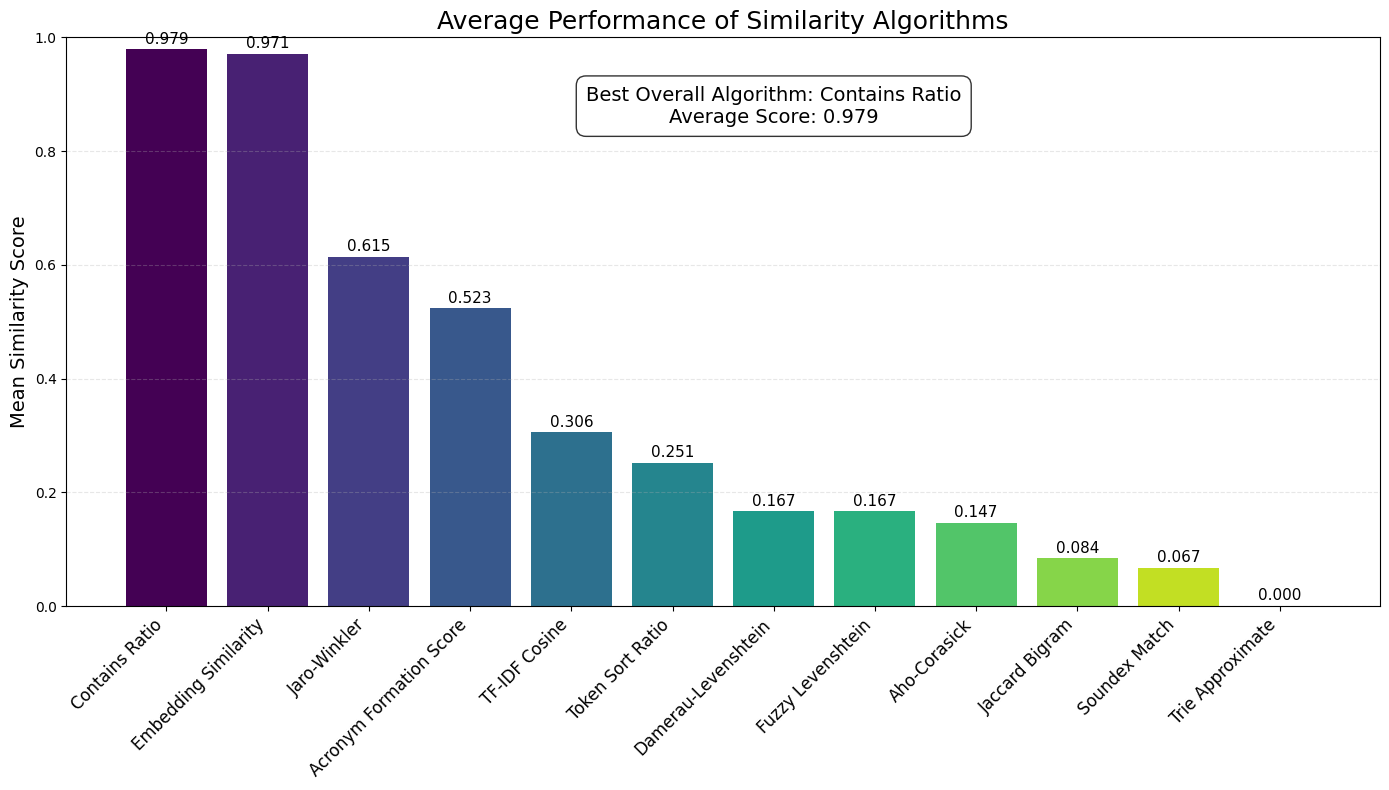


2. Detailed Analysis of Acronym Formation Score:


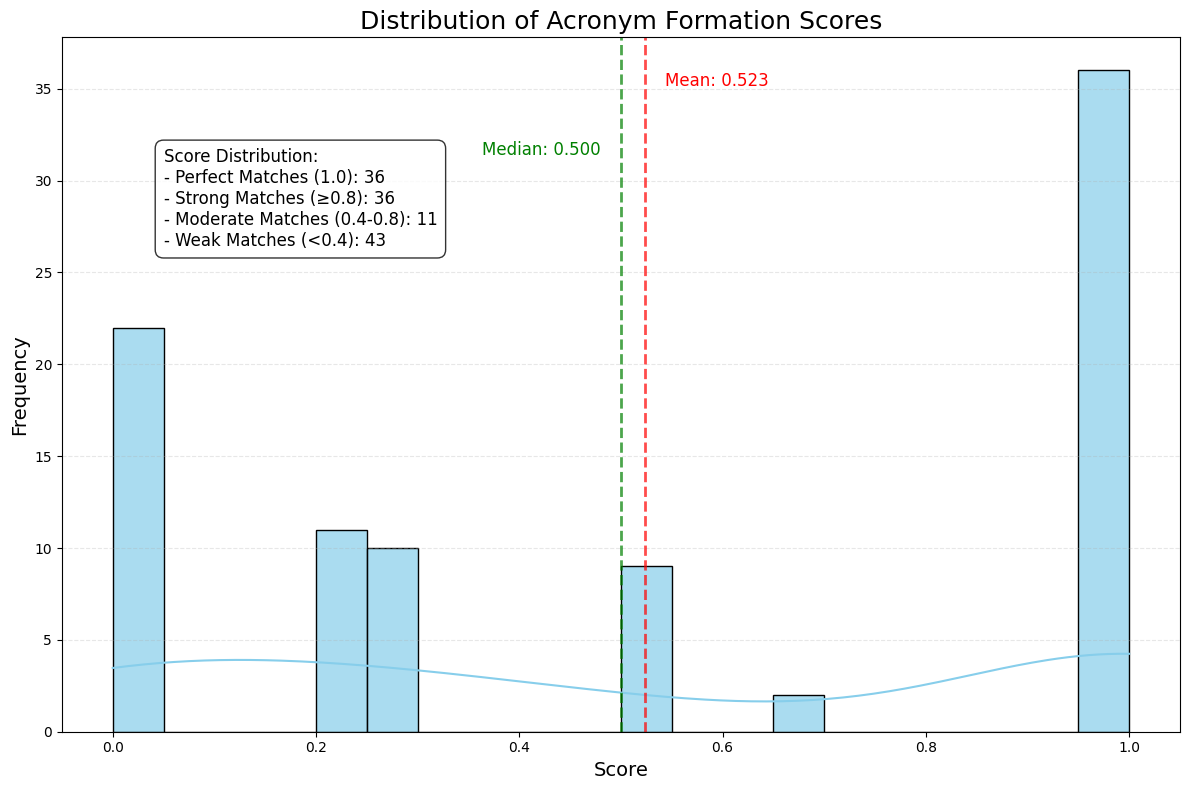


3. Case Study: McDonald's Acronym Variants:


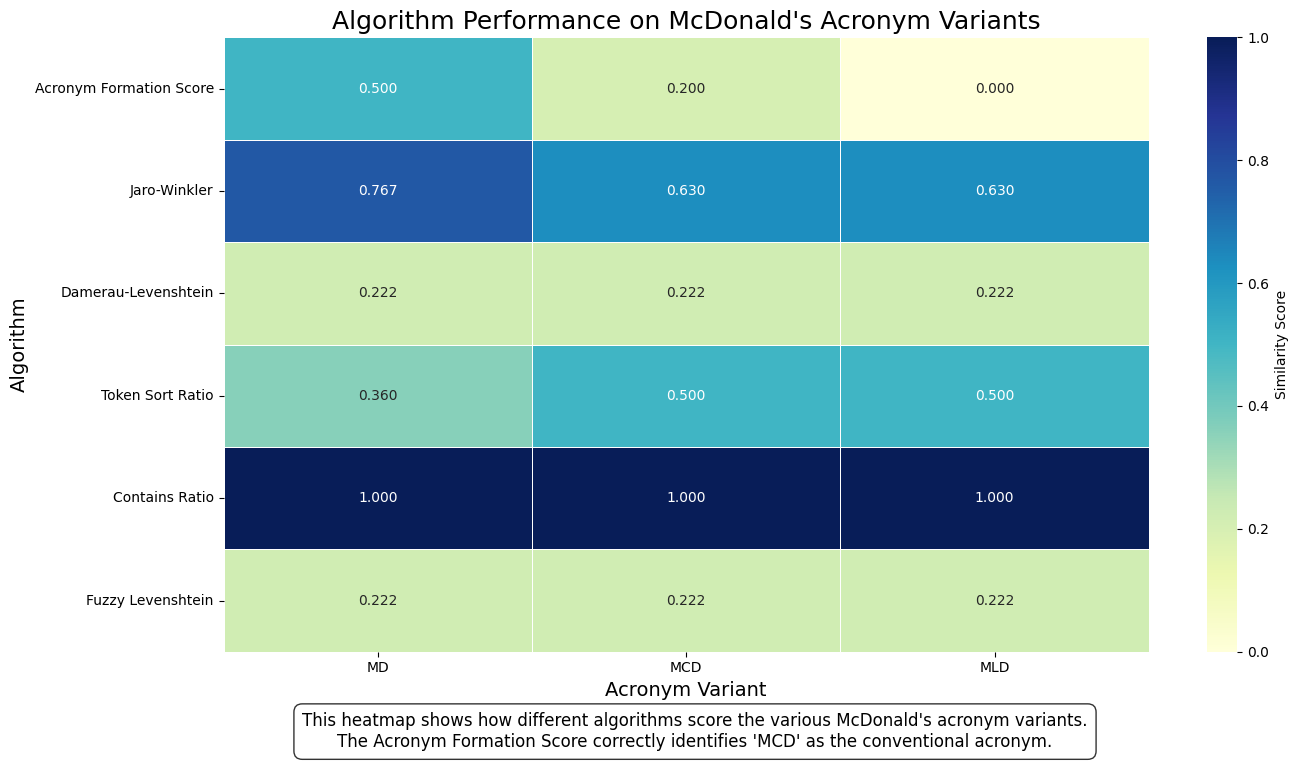


4. Algorithm Performance by Acronym Type:


<Figure size 1400x800 with 0 Axes>

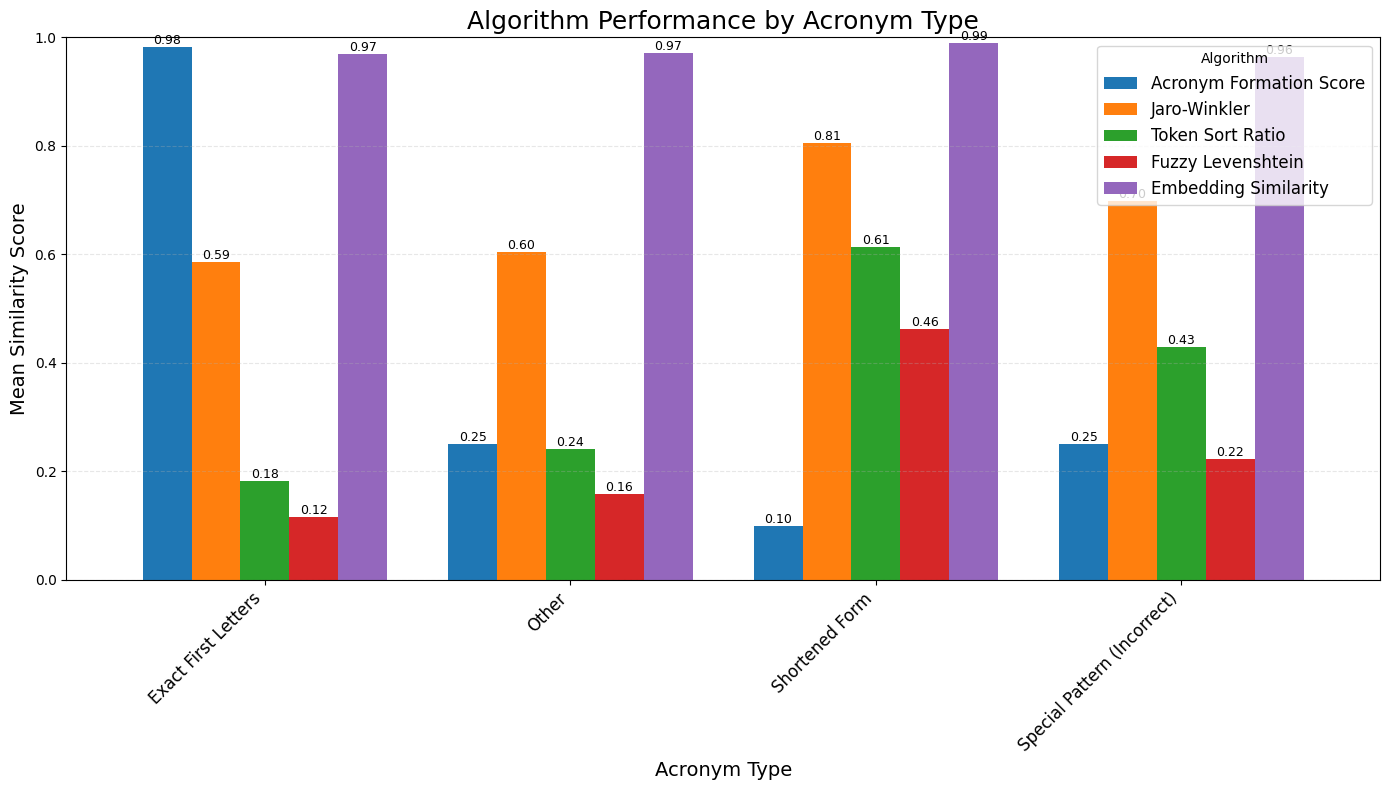


5. Distribution of Scores Across Algorithms:


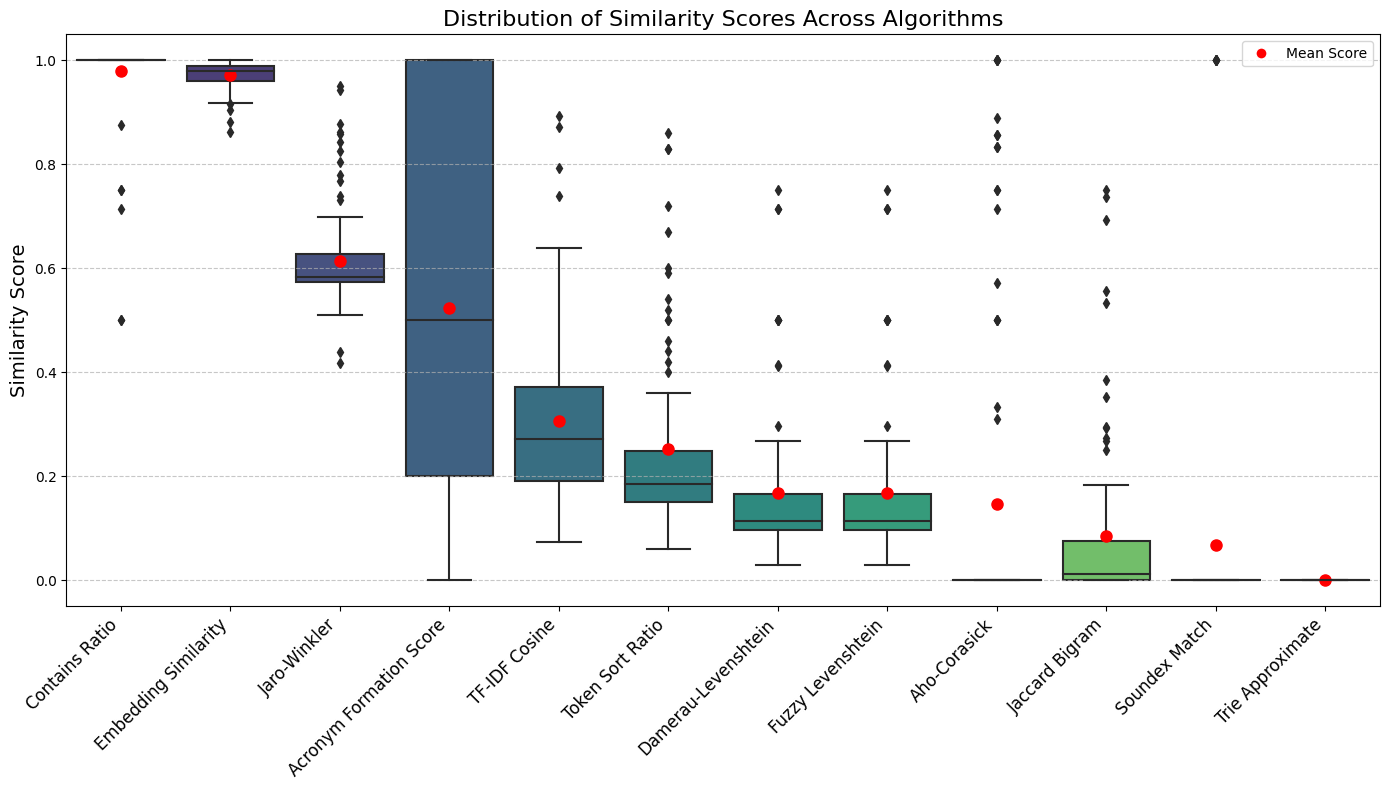


6. Correlation Between Different Algorithms:


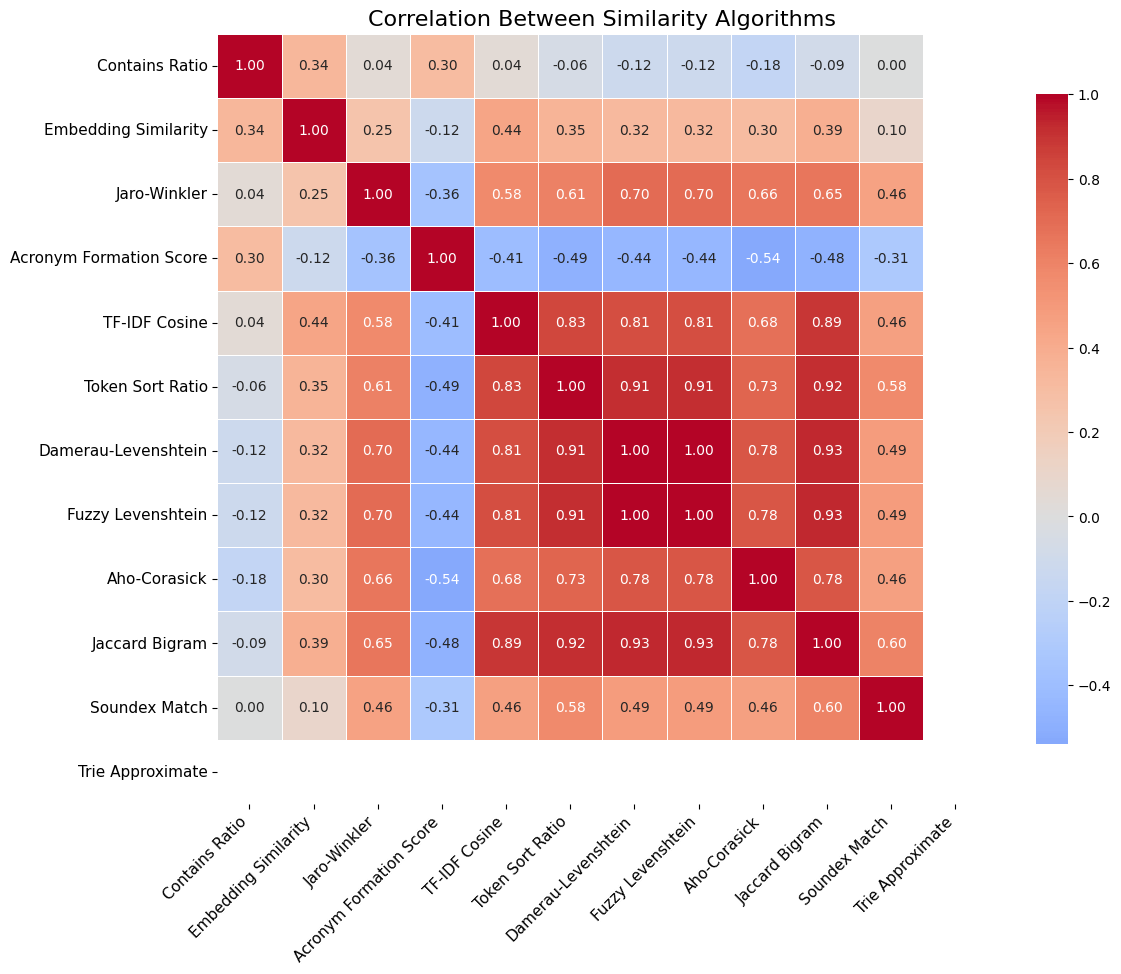


All visualizations displayed successfully.

=== COMPREHENSIVE ALGORITHM PERFORMANCE REPORT ===

SUMMARY STATISTICS:
       Jaro-Winkler  Damerau-Levenshtein  TF-IDF Cosine  Jaccard Bigram  \
count        90.000               90.000         90.000          90.000   
mean          0.615                0.167          0.306           0.084   
std           0.103                0.145          0.168           0.164   
min           0.418                0.029          0.074           0.000   
25%           0.574                0.096          0.191           0.000   
50%           0.583                0.114          0.272           0.011   
75%           0.627                0.165          0.372           0.074   
max           0.950                0.750          0.892           0.750   

       Soundex Match  Token Sort Ratio  Contains Ratio  Fuzzy Levenshtein  \
count         90.000            90.000          90.000             90.000   
mean           0.067             0.251           0.97

In [70]:
# Cell 12: Main Execution
if __name__ == '__main__':
    # Run full analysis
    result_df, performance_analysis = full_analysis()

In [74]:
pip install matplotlib seaborn pandas numpy networkx

Note: you may need to restart the kernel to use updated packages.
